In [64]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('../week3/Political-media-DFE.csv', encoding='latin1')

In [3]:
data.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...


>* Let's subset the DataFrame to have `label`, `source`, and `text` columns

In [4]:
df=data[['label', 'source', 'text']]

>* With this DataFrame, we want to extract the name of the user from the `label` column and create a new column called `username` in the DataFrame.

In [5]:
pattern=re.compile(r'(.+?)\s*\(')
df['username']=df['label'].str.replace('From: ', '').str.findall(pattern).str[0]

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/1246208881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['username']=df['label'].str.replace('From: ', '').str.findall(pattern).str[0]


>* Let's lowercase the `username` column

In [6]:
df['username']=df['username'].str.lower()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/3231511176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['username']=df['username'].str.lower()


> * Let's extract the mentions from the `text` column and create a new column `mention` with the mentions.

In [7]:
pattern = re.compile(r'@[a-zA-Z0-9]+')
df['mention']=df['text'].apply(lambda x: pattern.findall(x))
df['mention']=df['mention'].apply(lambda x: [y.lower() for y in x])

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/704253825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mention']=df['text'].apply(lambda x: pattern.findall(x))
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/704253825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mention']=df['mention'].apply(lambda x: [y.lower() for y in x])


>* We also don't want to forget to convert the text into lowercase.

In [8]:
df['text']=df['text'].str.lower()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/473300915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text']=df['text'].str.lower()


In [9]:
df.head(5)

,label,source,text,username,mention
0,From: Trey Radel (Representative from Florida),twitter,rt @nowthisnews: rep. trey radel (r- #fl) slam...,trey radel,[@nowthisnews]
1,From: Mitch McConnell (Senator from Kentucky),twitter,video - #obamacare: full of higher costs and ...,mitch mcconnell,[]
2,From: Kurt Schrader (Representative from Oregon),twitter,please join me today in remembering our fallen...,kurt schrader,[]
3,From: Michael Crapo (Senator from Idaho),twitter,rt @senatorleahy: 1st step toward senate debat...,michael crapo,[@senatorleahy]
4,From: Mark Udall (Senator from Colorado),twitter,.@amazon delivery #drones show need to update ...,mark udall,[@amazon]


> * Let's build edges between the users who have mentioned.
> * To do so, we will use the `mention` column and iterate over the rows to create edges between the users in the `mention` column.

>* There is an information about whether the political leader is a Representative or a Senator.
>* Let's use RegEx to extract that and create a dictionary called `title`.

In [10]:
pattern=re.compile(r'\([A-Za-z]*')
df['title']=df['label'].str.findall(pattern).str[0].str.strip('(')

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/738137026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title']=df['label'].str.findall(pattern).str[0].str.strip('(')


In [11]:
title={}
for idx, row in df.iterrows():
    title[row['username']]=row['title']

In [12]:
title_shape = {key: 'o' if value == 'Representative' else 'x' for key, value in title.items()}

>* There is another information about which State the political leader is from.
>* Let's use RegEx to extract that and create a dictionary called `state`.
>* We are changing the value of Representative and Senator to 'o' and 'x' to use it as a node shape.

In [13]:
pattern=re.compile(r'from\s.*')
df['state']=df['label'].str.findall(pattern).str[0].str.replace('from','').str.replace(')', '').str.strip()

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1776/1849310204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state']=df['label'].str.findall(pattern).str[0].str.replace('from','').str.replace(')', '').str.strip()


In [14]:
state={}
for idx, row in df.iterrows():
    state[row['username']]=row['state']

In [15]:
import random
import seaborn as sns
# Get the unique values from the state dictionary
unique_states = list(set(state.values()))

# Generate a color palette using seaborn
color_palette = sns.color_palette("hls", len(unique_states))

# Create a dictionary to map each unique state to a color
state_colors_dict = {key: color_palette[i] for i, key in enumerate(unique_states)}

In [16]:
from collections import defaultdict
default_dict=defaultdict(lambda: None, state)
for key, value in state.items():
    if value in state_colors_dict.keys():
        default_dict[key]=state_colors_dict.get(value)
color_mapped=dict(default_dict)

In [17]:
#first we need to iterate through the mention column and then we need to iterate through usernames column
#and we need to create a tuple of the username and the mention

edges=[]
for idx, val in df.iterrows():
    if len(val['mention']) == 0: #when there are no mentions, we skip the iteration
        continue
    elif len(val['mention']) > 0: #when there are mentions, we iterate through the mentions
        for mention in val['mention']: 
            edges.append((val['username'].lower(), mention.strip('@').lower())) 
            #we append the tuple of the username and the mention to the edges list
            #lower() is used to convert the username to lowercase
            #strip() is used to remove the @ from the mention

In [18]:
edges[:10]

[('trey radel', 'nowthisnews'),
 ('michael crapo', 'senatorleahy'),
 ('mark udall', 'amazon'),
 ('heidi heitkamp', 'usdotfra'),
 ('frederica wilson', 'bbcworld'),
 ('gregg harper', 'mha'),
 ('gregg harper', 'genevrapittman'),
 ('gregg harper', 'medcitynews'),
 ('john dingell', 'skitchp'),
 ('kirsten gillibrand', 'corybooker')]

>* We will generate an empty graph object `G` and populate the graph with the edges.

In [19]:
G = nx.Graph()

> * We will generate an empty directed graph object `D` and populate the graph with the edges.

In [98]:
D = nx.DiGraph(directed=True)

>* When you add edges, the graph object will add the nodes automatically.

In [20]:
G.add_edges_from(edges)

In [99]:
D.add_edges_from(edges)

>* Let's add node attributes.
>* We will add the `title` attributes to the node.

In [21]:
for node in G.nodes():
    if node in df['username'].values: #check if the node is in the username column
        G.nodes[node]['title']=df[df['username']==node]['title'].unique()[0]
    else: #if the node is not in the username column, we assign the title attribute as Unknown
        G.nodes[node]['title']='Unknown'

In [100]:
for node in D.nodes():
    if node in df['username'].values:
        D.nodes[node]['title']=df[df['username']==node]['title'].unique()[0]
    else:
        D.nodes[node]['title']='Unknown'

>* We will add the `state` attributes to the node.
>* Similarly, we will add `Unknown` to the nodes that are not in the `df['username']`.

In [22]:
for node in G.nodes():
    if node in df['username'].values:
        G.nodes[node]['state']=df[df['username']==node]['state'].unique()[0]
    else:
        G.nodes[node]['state']='Unknown'

In [101]:
for node in D.nodes():
    if node in df['username'].values:
        D.nodes[node]['state']=df[df['username']==node]['state'].unique()[0]
    else:
        D.nodes[node]['state']='Unknown'

>* Now that we have a dictionary, `color_mapped` that as usernames as keys and the value for RGB as values, we can use this dictionary to add the color to the nodes.

In [23]:
for node in G.nodes():
    if node in df['username'].values:
        G.nodes[node]['color']=color_mapped[node]
    else:
        G.nodes[node]['color']=(0,0,0)

In [102]:
for node in D.nodes():
    if node in df['username'].values:
        D.nodes[node]['color']=color_mapped[node]
    else:
        D.nodes[node]['color']=(0,0,0)

In [24]:
color_mapped['trey radel']

(0.49355294117647014, 0.33999999999999997, 0.86)

>* Let's set node attributes for degree centrality.

In [25]:
nx.set_node_attributes(G, nx.degree_centrality(G), 'degree')

>* For the directed graph, we will calculate the in-degree and out-degree centrality.

In [103]:
nx.set_node_attributes(D, nx.in_degree_centrality(D), 'in_degree')
nx.set_node_attributes(D, nx.out_degree_centrality(D), 'out_degree')

>* Let's set node attributes for betweenness centrality.

In [26]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')

In [104]:
nx.set_node_attributes(D, nx.betweenness_centrality(D), 'betweenness')

>* Let's set node attributes for closeness centrality.

In [27]:
nx.set_node_attributes(G, nx.closeness_centrality(G), 'closeness')

In [105]:
nx.set_node_attributes(D, nx.closeness_centrality(D), 'closeness')

>* In total, we have added `title`, `state`, `color`, `degree centrality`, `betweenness centrality`, and `closeness centrality` attributes to the nodes.

In [28]:
G.nodes['trey radel']

{'title': 'Representative',
 'state': 'Florida',
 'color': (0.49355294117647014, 0.33999999999999997, 0.86),
 'degree': 0.0027731558513588465,
 'betweenness': 6.155728859842057e-06,
 'closeness': 0.0027731558513588465}

In [106]:
D.nodes['trey radel']

{'title': 'Representative',
 'state': 'Florida',
 'color': (0.49355294117647014, 0.33999999999999997, 0.86),
 'in_degree': 0.0,
 'out_degree': 0.0027731558513588465,
 'betweenness': 0.0,
 'closeness': 0.0}

>* When drawing the graph, the location of the nodes will be determined randomly.
>* By specifying the `pos` parameter, we can set the location of the nodes.
>* First, we will have `kamada_kawai_layout` to set the location of the nodes.
>* The position of the nodes will be determined by Kamada-Kawai path-length cost-function.
>* See details here: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html

In [107]:
pos=nx.kamada_kawai_layout(G)

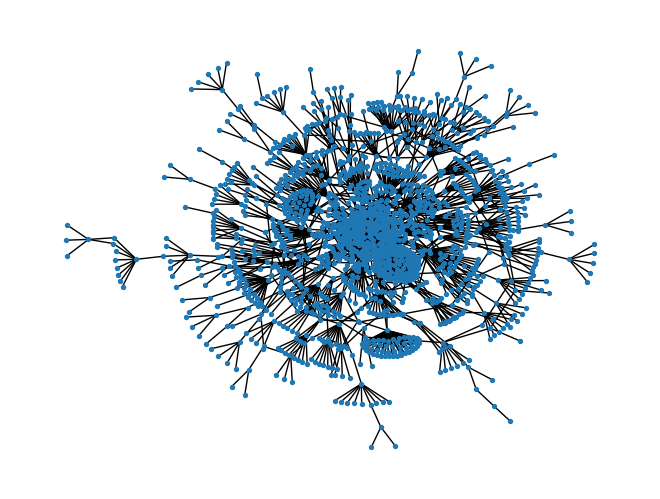

In [30]:
nx.draw(G, pos=pos, node_size=8)
#, node_color=[G.nodes[node]['color'] for node in G.nodes()])
#we set the node color to represent the state of the politician

>* Another layout is `spring_layout`.
>* The positions of the nodes will be determined by Fruchterman-Reingold force-directed algorithm.
>* See details here: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

In [31]:
pos=nx.spring_layout(G)

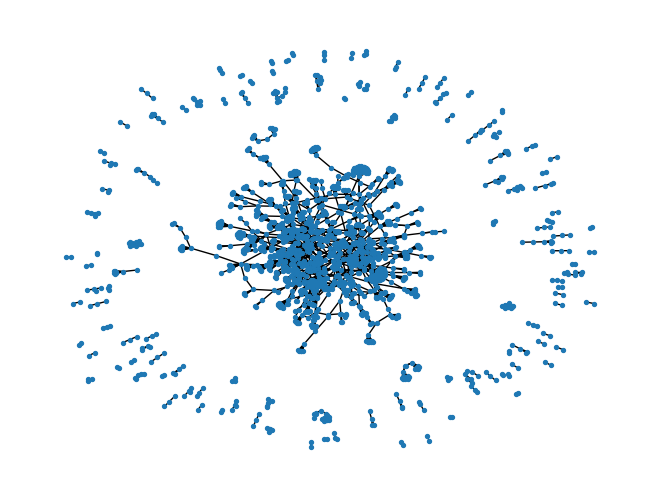

In [32]:
nx.draw(G, pos=pos, node_size=8)
#, node_size=8, node_color=[G.nodes[node]['color'] for node in G.nodes()])
#we set the node color to represent the state of the politician

>* Lastly, though it is not recommended, it is `random_layout`.
>* The positions of the nodes will be determined randomly.

In [33]:
pos=nx.random_layout(G)

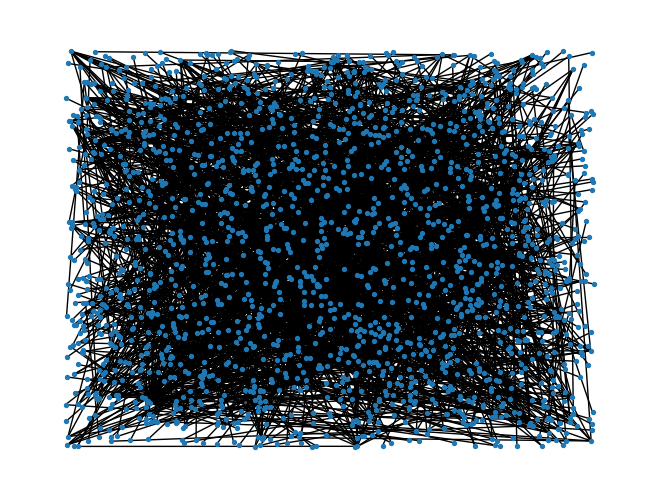

In [34]:
nx.draw(G, pos=pos, node_size=8)

>* Once we deterimine the layout, we can specify the `node size`, `node color`, and `node shape`.

>* We can change the size of nodes based on the `degree centrality`.
>* In nx.draw, we can specify the `node_size` parameter to change the size of the nodes.
>* We will use the value of `degree centrality` to decide the size of the nodes.

In [35]:
pos=nx.kamada_kawai_layout(G)

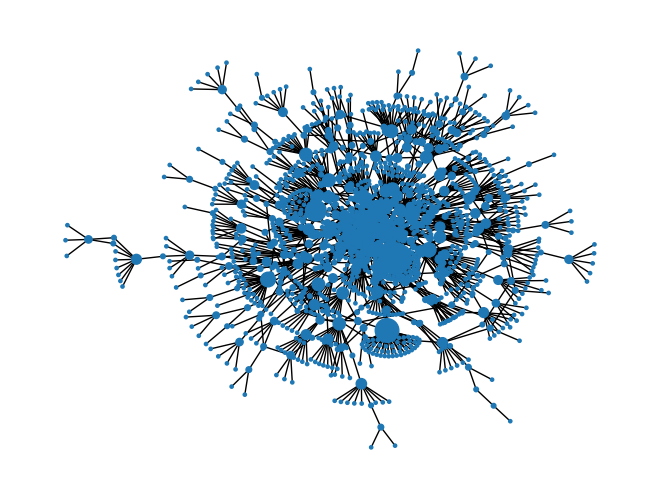

In [36]:
nx.draw(G, pos=pos, node_size=[G.nodes[node]['degree']*10000 for node in G.nodes()])

>* We can change the color of the nodes based on the `state`.
>* In nx.draw, we can use the `node_color` parameter to specify the color of the nodes.
>* We can combine the size of the node with `degree centrality` and the color of the node with `state`.

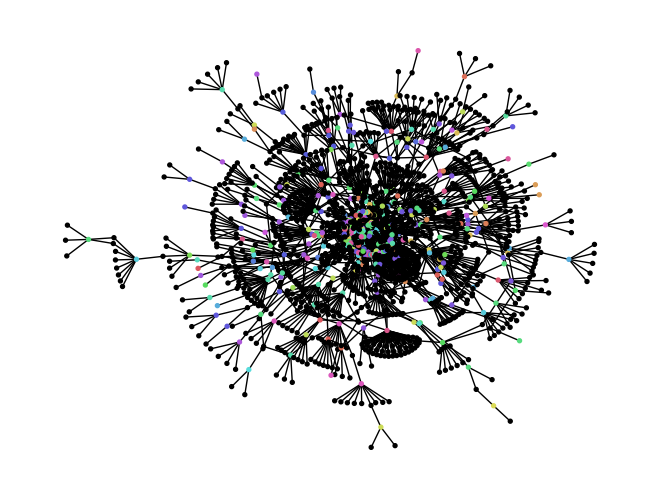

In [37]:
nx.draw(G, pos=pos, node_size=8, node_color=[G.nodes[node]['color'] for node in G.nodes()])

>* Changing node shape based on the `title` attribute.
>* In nx.draw, we can use the `node_shape` parameter to specify the shape of the nodes.
>* However, we have `Senator` and `Representative` as values in the `title` attribute. We need to change them to 'o' and 'x' to use them as node shapes.

In [38]:
for node in G.nodes():
    if G.nodes[node]['title'] == 'Representative':
        G.nodes[node]['shape']='o'
    elif G.nodes[node]['title'] == 'Senator':
        G.nodes[node]['shape']='x'
    elif G.nodes[node]['title'] == 'Unknown':
        G.nodes[node]['shape']='s'

>* Unfortunately, NetworkX does not support drawing nodes with different shapes at the same time.

ValueError: Unrecognized marker style ['o', 's', 'x', 's', 'x', 's', 'x', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 'x', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 'x', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 'x', 's', 'x', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 'o', 's', 'o', 's', 'o', 's', 'o', 's', 'x', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 'o', 's', 'x', 's', 'x', 'o', 's', 'x', 's', 'o', 's', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 'x', 's', 'x', 's', 'o', 's', 'o', 's', 'o', 's', 'x', 's', 's', 'o', 's', 'o', 's', 'o', 's', 'x', 's', 'o', 's', 's', 's', 's', 'o', 's', 'x', 's', 'o', 'o', 's', 's', 'x', 's', 's', 'o', 's', 'x', 's', 'x', 's', 's', 's', 'o', 's', 'o', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 'o', 's', 'x', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 'o', 's', 'o', 's', 'o', 's', 's', 'o', 's', 'o', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 'x', 's', 'o', 's', 'x', 's', 'o', 's', 's', 'x', 's', 'o', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 's', 'o', 's', 'x', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 'x', 's', 's', 's', 'o', 's', 's', 'x', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'x', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 'x', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 'x', 'o', 's', 'o', 's', 's', 's', 's', 's', 'o', 'o', 's', 's', 'x', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 'o', 's', 'x', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 'x', 's', 's', 's', 's', 'o', 'o', 's', 's', 'o', 's', 'x', 's', 's', 's', 'o', 's', 's', 's', 'x', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 'x', 's', 's', 's', 's', 'x', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 'x', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 'o', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 'x', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 'o', 'o', 's', 's', 's', 's', 'x', 'o', 's', 'o', 'o', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'x', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'x', 's', 'x', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'x', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'x', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'x', 's', 's', 'x', 'x', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'x', 's', 'o', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 'o', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 'x', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 'o', 's', 'x', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 'o', 's', 's', 's', 'o', 's', 's', 's', 's', 'x', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 'o', 's', 's', 'x', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 'x', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'x', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'x', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 'x', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 'o', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'x', 's', 's', 'o', 's', 's', 's', 'o', 's']

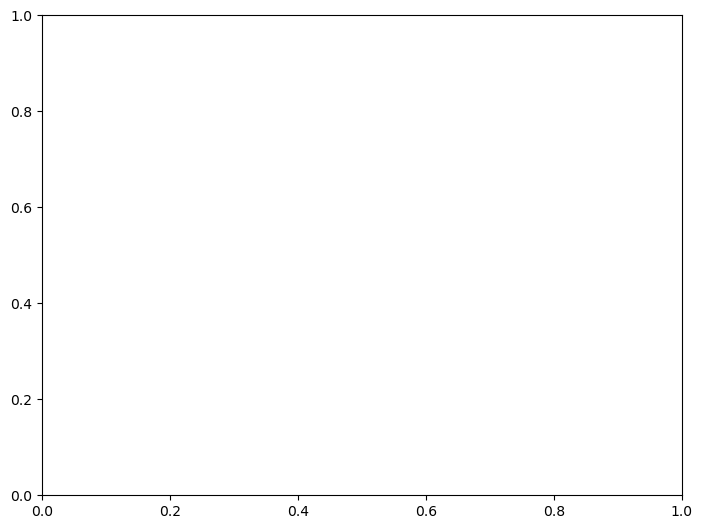

In [39]:
nx.draw(G, pos=pos, node_size=8, node_shape=[G.nodes[node]['shape'] for node in G.nodes()])

>* To avoid the error, we will need to use the `draw_networkx_nodes` function to draw the nodes with different shapes separately.

>* First, we will collect the name of the nodes and save them in different variables.

In [40]:
Senator_nodes=[node for node in G.nodes() if G.nodes[node]['title']=='Senator']
Representative_nodes=[node for node in G.nodes() if G.nodes[node]['title']=='Representative']
Unknown_nodes=[node for node in G.nodes() if G.nodes[node]['title']=='Unknown']

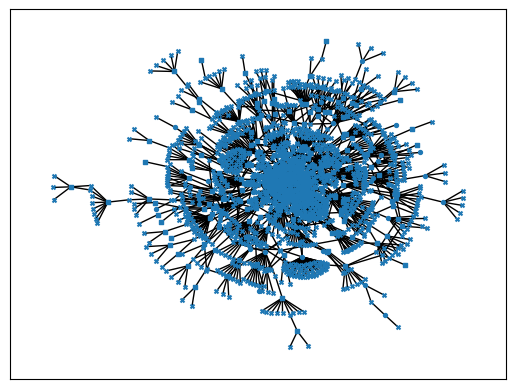

In [41]:
nx.draw_networkx_nodes(G,pos,nodelist=Senator_nodes,node_shape='o', node_size=8)
nx.draw_networkx_nodes(G,pos,nodelist=Representative_nodes,node_shape='s', node_size=8) 
nx.draw_networkx_nodes(G,pos,nodelist=Unknown_nodes,node_shape='x', node_size=8)
nx.draw_networkx_edges(G,pos)

>* You can put the `node size`, `node color`, and `node shape` parameters in the `draw_networkx_nodes` function at the same time.

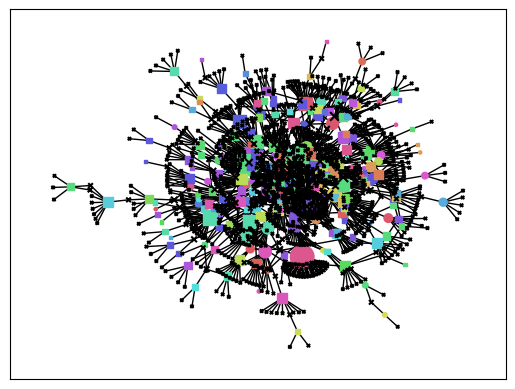

In [42]:
nx.draw_networkx_nodes(G,pos,nodelist=Senator_nodes,node_shape='o',
                       node_size=[G.nodes[node]['degree']*10000 for node in Senator_nodes],
                       node_color=[G.nodes[node]['color'] for node in Senator_nodes])
nx.draw_networkx_nodes(G,pos,nodelist=Representative_nodes,node_shape='s',
                       node_size=[G.nodes[node]['degree']*10000 for node in Representative_nodes], 
                       node_color=[G.nodes[node]['color'] for node in Representative_nodes]) 
nx.draw_networkx_nodes(G,pos,nodelist=Unknown_nodes,node_shape='x', 
                       node_size=[G.nodes[node]['degree']*10000 for node in Unknown_nodes], 
                       node_color=[G.nodes[node]['color'] for node in Unknown_nodes])
nx.draw_networkx_edges(G,pos)

>* The direction of the edges can be drawn with `nx.draw_networkx_edges`.
>* This will only draw edges between the nodes. So, nodes should be drawn separately.

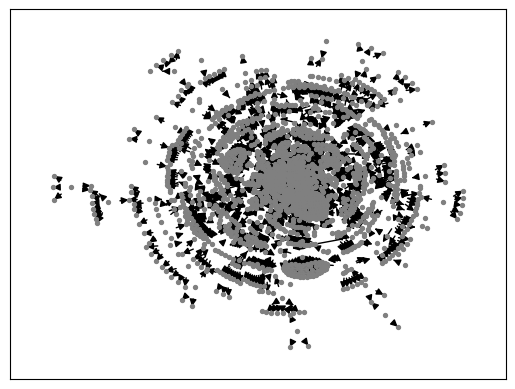

In [149]:
nx.draw_networkx_nodes(D, pos=pos, node_size=8, node_color='grey')
nx.draw_networkx_edges(D, pos=pos, arrowstyle='-|>', arrowsize=10,
                       nodelist=[node for node in D.nodes()])

plt.show() #This is to omit the text output

>* We can change the size of the nodes based on the `in-degree centrality` and `out-degree centrality`.

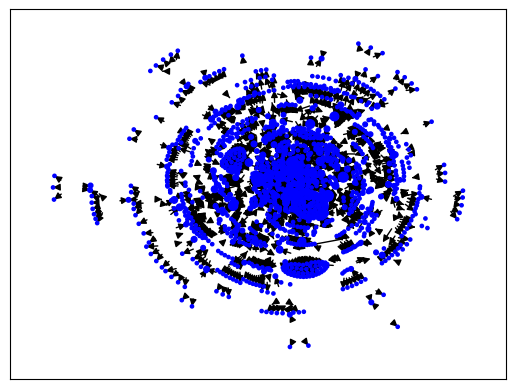

In [113]:
nx.draw_networkx_nodes(D, pos=pos, node_size=[D.nodes[node]['in_degree']*10000 for node in D.nodes()],
                       node_color='blue')
nx.draw_networkx_edges(D, pos=pos, arrowstyle='-|>', arrowsize=10,
                       nodelist=[node for node in D.nodes()])
plt.show() #This is to omit the text output

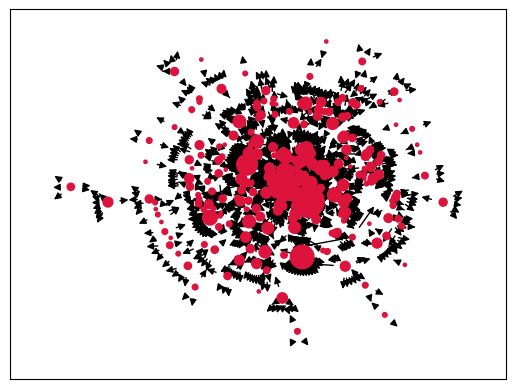

In [118]:
nx.draw_networkx_nodes(D, pos=pos, node_size=[D.nodes[node]['out_degree']*10000 for node in D.nodes()],
                       node_color='crimson')
nx.draw_networkx_edges(D, pos=pos, arrowstyle='-|>', arrowsize=10,
                       nodelist=[node for node in D.nodes()])
plt.show() #This is to omit the text output

>* Q. Do you see any difference between the visualization based on `in-degree centrality` and `out-degree centrality`? Why there are some nodes disappeared?

>* You can have different styles for the edges

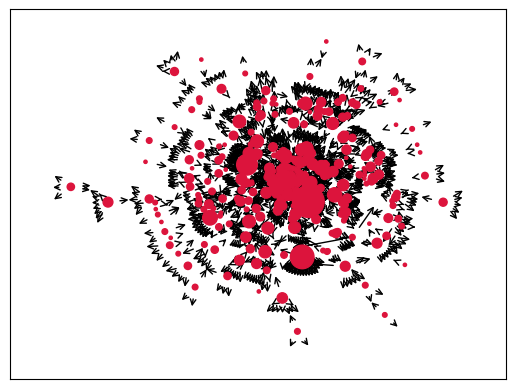

In [119]:
nx.draw_networkx_nodes(D, pos=pos, node_size=[D.nodes[node]['out_degree']*10000 for node in D.nodes()],
                       node_color='crimson')
nx.draw_networkx_edges(D, pos=pos, arrowstyle='->', arrowsize=10,
                       nodelist=[node for node in D.nodes()])
plt.show() #This is to omit the text output

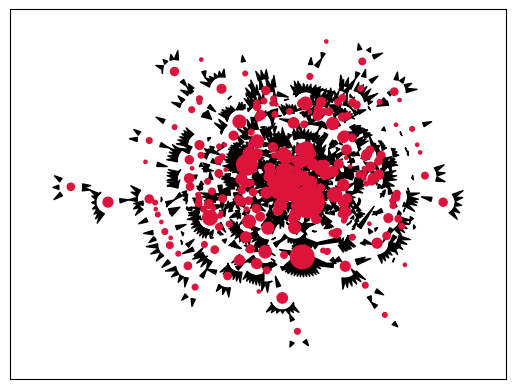

In [123]:
nx.draw_networkx_nodes(D, pos=pos, node_size=[D.nodes[node]['out_degree']*10000 for node in D.nodes()],
                       node_color='crimson')
nx.draw_networkx_edges(D, pos=pos, arrowstyle='wedge', arrowsize=10,
                       nodelist=[node for node in D.nodes()])
plt.show() #This is to omit the text output

>* There are other layouts available in NetworkX.
>* Depending on the connection between the nodes, you may want to use a different layout.

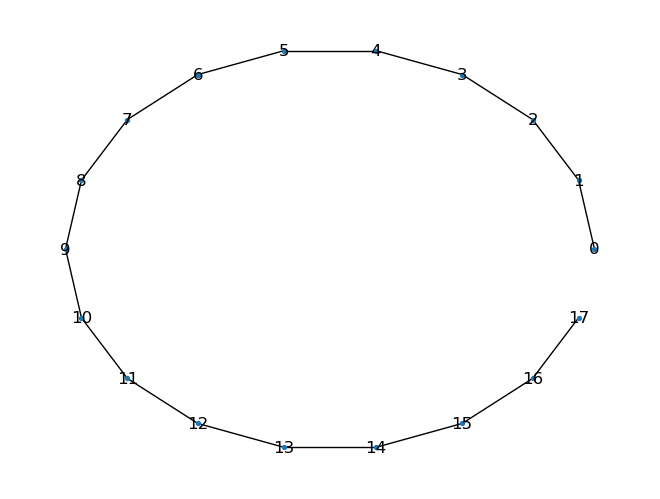

In [135]:
P = nx.path_graph(18)
nx.draw_circular(P, with_labels=True, node_size=8)

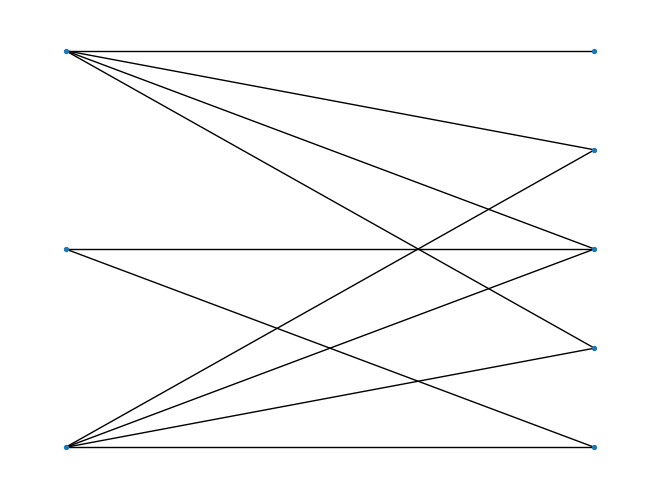

In [136]:
P = nx.bipartite.gnmk_random_graph(3, 5, 10, seed=123)
top = nx.bipartite.sets(P)[0]
pos = nx.bipartite_layout(P, top)
nx.draw(P, pos=pos, node_size=8)

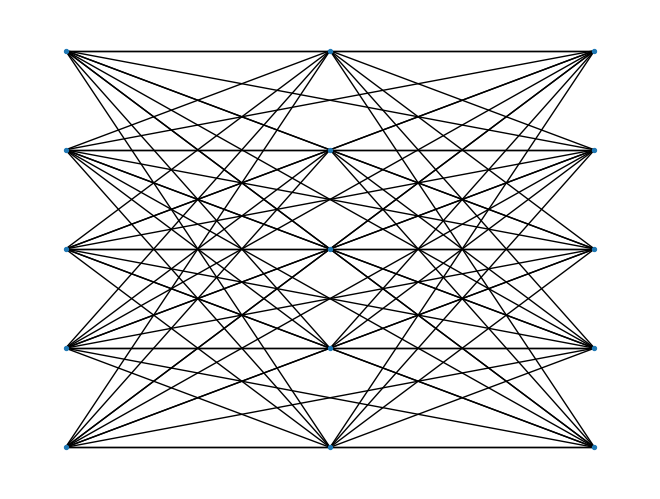

In [137]:
P = nx.complete_multipartite_graph(5, 5, 5)
pos = nx.multipartite_layout(P)
nx.draw(P, pos=pos, node_size=8)

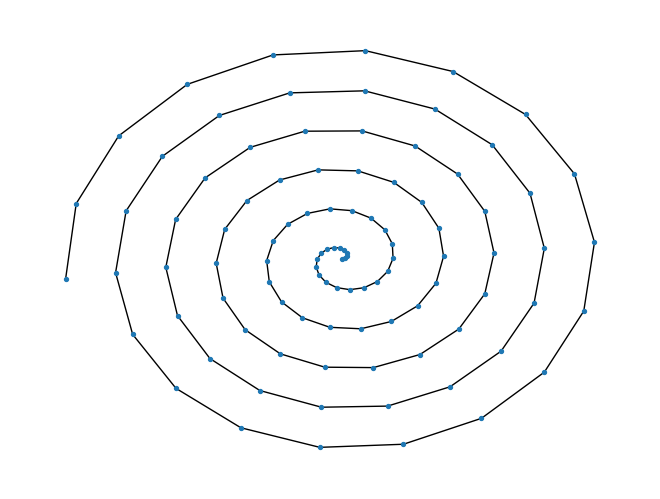

In [138]:
P = nx.path_graph(100)
pos = nx.spiral_layout(P)
nx.draw(P, pos=pos, node_size=8)

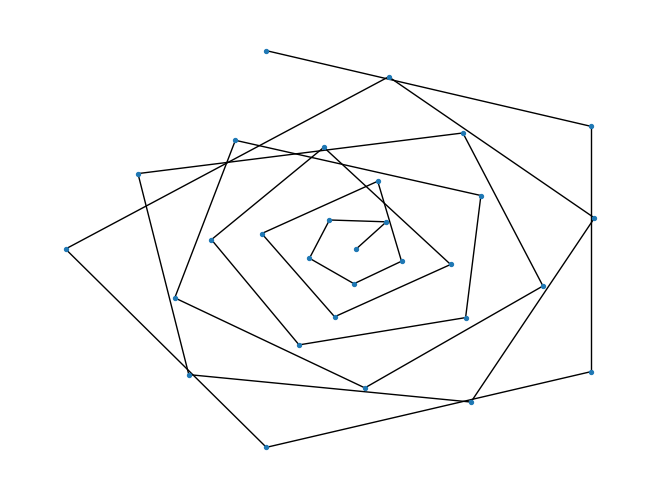

In [139]:
P = nx.path_graph(30)
shells = [[0], [1, 2, 3, 4, 5], [6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19], [20, 21, 22, 23, 24], [25, 26, 27, 28, 29]]
pos = nx.shell_layout(G, shells)
nx.draw(P, pos=pos, node_size=8)